In [1]:
from xmip.utils import google_cmip_col
from xmip.preprocessing import combined_preprocessing
from xmip.postprocessing import concat_experiments, pick_first_member, _drop_duplicate_grid_labels #TODO:  _drop_duplicate_grid_labels should be public?

In [2]:
col = google_cmip_col()
col

,unique
activity_id,18
institution_id,36
source_id,88
experiment_id,170
member_id,657
table_id,37
variable_id,700
grid_label,10
zstore,514818
dcpp_init_year,60


In [3]:
source_ids = [s for s in sorted(col.df['source_id'].unique()) if s not in ['AWI-CM-1-1-MR','AWI-ESM-1-1-LR']]

In [4]:
cat = col.search(
    variable_id='tos', 
    experiment_id=['historical', 'ssp245'], 
    table_id='Omon', 
    source_id=source_ids,
    # Check out the two failure models from below:
    # source_id = ['IP'],
    require_all_on=['source_id', 'grid_label', 'member_id']
)
cat

,unique
activity_id,2
institution_id,26
source_id,40
experiment_id,2
member_id,137
table_id,1
variable_id,1
grid_label,3
zstore,686
dcpp_init_year,0


In [5]:
# Loading all these datasets into xarray takes long, but not prohibitively long (few minutes). 
# As a more perfomant option one could work some pandas magic and select members based on availability of both experiments, and filter out grid_labels.
# For this purpose Ill take the slightly longer loading time.

# Could look something like this:
# def prune_members(df):
#     return df.iloc[0]

# df = cat.df
# pruned_df = df.groupby([c for c in df.columns if c not in ['member_id', 'zstore', 'dcpp_init_year']], group_keys=False, as_index=False).apply(prune_members)
# cat.esmcat._df = pruned_df
# cat

ddict = cat.to_dataset_dict(aggregate=False, preprocess=combined_preprocessing)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.member_id.table_id.variable_id.grid_label.zstore.dcpp_init_year.version'


/srv/conda/envs/notebook/lib/python3.10/site-packages/xmip/preprocessing.py:96: UserWarning: CMIP.MIROC.MIROC6.historical.r12i1p1f1.Omon.gn.none.tos:While renaming to target `lon_bounds`, more than one candidate was found ['x_bnds', 'vertices_longitude']. Renaming x_bnds to lon_bounds. Please double check results.
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.10/site-packages/xmip/preprocessing.py:96: UserWarning: CMIP.MIROC.MIROC6.historical.r12i1p1f1.Omon.gn.none.tos:While renaming to target `lat_bounds`, more than one candidate was found ['y_bnds', 'vertices_latitude']. Renaming y_bnds to lat_bounds. Please double check results.
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.10/site-packages/xmip/preprocessing.py:287: UserWarning: `FGOALS-f3-L` does not provide lon or lat bounds.
  warnings.warn("`FGOALS-f3-L` does not provide lon or lat bounds.")
/srv/conda/envs/notebook/lib/python3.10/site-packages/xmip/preprocessing.py:96: UserWarning: ScenarioMIP.MIROC.MIROC6.ssp2

In [16]:
# One of the models has the dimensions i/j labelled differently(incorrectly? See https://github.com/jbusecke/xMIP/issues/311 for discussion)
ddict_fixed = {name:ds.rename({'x':'y', 'y':'x'}) if 'CMCC' in ds.attrs['source_id'] else ds for name, ds in ddict.items()}

In [17]:
# Postprocessing steps: Concat experiments, pick only first member and pick only one grid label (regridded preferred)
ddict_concat = concat_experiments(ddict_fixed)
ddict_first = pick_first_member(ddict_concat)
ddict_pruned = _drop_duplicate_grid_labels(ddict_first, 'gr')

/srv/conda/envs/notebook/lib/python3.10/site-packages/xmip/postprocessing.py:89: UserWarning: Match attributes ['experiment_id'] not found in any of the datasets.         This can happen when several combination functions are used and attributes are removed during merging.         Double check the results.
  warnings.warn(


In [18]:
# there is a double entry for EC-Earth
# TODO: investigate why
# for now quick fix
ddict_pruned = {k:ds for k,ds in ddict_pruned.items() if k not in ['EC-Earth3.Omon.r101i1p1f1.tos.tos']}

In [19]:
sorted(list(ddict_pruned.keys()))

['ACCESS-CM2.Omon.r1i1p1f1.tos.tos',
 'BCC-CSM2-MR.Omon.r1i1p1f1.tos.tos',
 'CAMS-CSM1-0.Omon.r1i1p1f1.tos.tos',
 'CESM2-WACCM.Omon.r1i1p1f1.tos.tos',
 'CESM2.Omon.r10i1p1f1.tos.tos',
 'CIESM.Omon.r1i1p1f1.tos.tos',
 'CMCC-CM2-SR5.Omon.r1i1p1f1.tos.tos',
 'CMCC-ESM2.Omon.r1i1p1f1.tos.tos',
 'CNRM-CM6-1-HR.Omon.r1i1p1f2.tos.tos',
 'CNRM-CM6-1.Omon.r10i1p1f2.tos.tos',
 'CNRM-ESM2-1.Omon.r10i1p1f2.tos.tos',
 'CanESM5-CanOE.Omon.r1i1p2f1.tos.tos',
 'CanESM5.Omon.r10i1p1f1.tos.tos',
 'EC-Earth3-CC.Omon.r1i1p1f1.tos.tos',
 'EC-Earth3-Veg-LR.Omon.r1i1p1f1.tos.tos',
 'EC-Earth3-Veg.Omon.r2i1p1f1.tos.tos',
 'EC-Earth3.Omon.r10i1p1f1.tos.tos',
 'FGOALS-f3-L.Omon.r1i1p1f1.tos.tos',
 'FGOALS-g3.Omon.r1i1p1f1.tos.tos',
 'FIO-ESM-2-0.Omon.r1i1p1f1.tos.tos',
 'GFDL-CM4.Omon.r1i1p1f1.tos.tos',
 'GFDL-ESM4.Omon.r1i1p1f1.tos.tos',
 'GISS-E2-1-G.Omon.r10i1p1f2.tos.tos',
 'HadGEM3-GC31-LL.Omon.r1i1p1f3.tos.tos',
 'IITM-ESM.Omon.r1i1p1f1.tos.tos',
 'INM-CM4-8.Omon.r1i1p1f1.tos.tos',
 'INM-CM5-0.Omon.r1i1p1

In [20]:
# Cut to the time frame desired (1990-2019)
ddict_time_selected = {k:ds.sel(time=slice('1990', '2019')) for k,ds in ddict_pruned.items()}
# make sure all the datasets have the same length in time
assert len(set([len(ds.time) for ds in ddict_time_selected.values()])) == 1

In [22]:
# load all datasets into memory to speed this up
from tqdm.auto import tqdm

ddict_loaded = {}
for k, ds in tqdm(ddict_time_selected.items()):
    print(k)
    ddict_loaded[k] = ds.load()

  0%|          | 0/40 [00:00<?, ?it/s]

CNRM-CM6-1.Omon.r10i1p1f2.tos.tos
CAMS-CSM1-0.Omon.r1i1p1f1.tos.tos
CanESM5.Omon.r10i1p1f1.tos.tos
NESM3.Omon.r1i1p1f1.tos.tos
CNRM-CM6-1-HR.Omon.r1i1p1f2.tos.tos
MIROC-ES2L.Omon.r10i1p1f2.tos.tos
FGOALS-f3-L.Omon.r1i1p1f1.tos.tos
FIO-ESM-2-0.Omon.r1i1p1f1.tos.tos
MIROC6.Omon.r10i1p1f1.tos.tos
GFDL-ESM4.Omon.r1i1p1f1.tos.tos
NorESM2-LM.Omon.r1i1p1f1.tos.tos
ACCESS-CM2.Omon.r1i1p1f1.tos.tos
CNRM-ESM2-1.Omon.r10i1p1f2.tos.tos
EC-Earth3.Omon.r10i1p1f1.tos.tos
CESM2-WACCM.Omon.r1i1p1f1.tos.tos
GISS-E2-1-G.Omon.r10i1p1f2.tos.tos
EC-Earth3-Veg.Omon.r2i1p1f1.tos.tos
CIESM.Omon.r1i1p1f1.tos.tos
CESM2.Omon.r10i1p1f1.tos.tos
IPSL-CM6A-LR.Omon.r10i1p1f1.tos.tos
TaiESM1.Omon.r1i1p1f1.tos.tos
HadGEM3-GC31-LL.Omon.r1i1p1f3.tos.tos
NorESM2-MM.Omon.r1i1p1f1.tos.tos
EC-Earth3-Veg-LR.Omon.r1i1p1f1.tos.tos
MCM-UA-1-0.Omon.r1i1p1f2.tos.tos
BCC-CSM2-MR.Omon.r1i1p1f1.tos.tos
KACE-1-0-G.Omon.r1i1p1f1.tos.tos
MPI-ESM1-2-LR.Omon.r10i1p1f1.tos.tos
CanESM5-CanOE.Omon.r1i1p2f1.tos.tos
GFDL-CM4.Omon.r1i1p1f1.tos.t

In [28]:
# compute the linear trend
import xarray as xr

def calculate_linear_trend(ds):
    attrs = ds.attrs
    da = ds.tos.squeeze().load()
    coeffs = da.polyfit('time', 1)
    # evaluate trend coefficients
    trend = xr.polyval(ds.time, coeffs.polyfit_coefficients)
    # compute the linear trend difference between beginning and end
    diff = trend.isel(time=[0,-1]).diff('time').squeeze()
    diff = diff.assign_coords({k:ds[k] for k in ['lon', 'lat']})
    diff.attrs = attrs
    return diff

ddict_trends = {}
for k, ds in tqdm(ddict_loaded.items()):
    ddict_trends[k] = calculate_linear_trend(ds)

  0%|          | 0/40 [00:00<?, ?it/s]

In [52]:
# Last step: Interpolate the trend maps on a commmon grid
# NOTE: I could have done this before, and then taken the linear trend, but this should be a lot more efficient.
import xesmf as xe

target_grid = xe.util.grid_global(1, 1) # interpolate on regular 1 deg grid. 
# Might want to put this to a higher res as some models have higher native resolution
# and we might be aliasing.
# But should be ok for a first take
datasets = []
for model, ds in ddict_trends.items():
    print(model)
    # make sure only lon/lat have values
    ds = ds.drop([dim for dim in ['x', 'y', 'longitude', 'latitude'] if dim in ds.dims])

    # fix datasets with wrapped array boundaries(these cause stripes in the regridded data)
    if len(ds.x) == 362:
        print(model)
        ds = ds.isel(x=slice(1,-1))

    regridder = xe.Regridder(
        ds,
        target_grid,
        method='bilinear',
        periodic=True,
        ignore_degenerate=True, 
        unmapped_to_nan=True,
        extrap_method='nearest_s2d',
    )
    ds_regridded = regridder(ds).assign_coords(model=model.split('.')[0])
    datasets.append(ds_regridded)

CNRM-CM6-1.Omon.r10i1p1f2.tos.tos
CNRM-CM6-1.Omon.r10i1p1f2.tos.tos
CAMS-CSM1-0.Omon.r1i1p1f1.tos.tos
CanESM5.Omon.r10i1p1f1.tos.tos
NESM3.Omon.r1i1p1f1.tos.tos
NESM3.Omon.r1i1p1f1.tos.tos
CNRM-CM6-1-HR.Omon.r1i1p1f2.tos.tos
MIROC-ES2L.Omon.r10i1p1f2.tos.tos
FGOALS-f3-L.Omon.r1i1p1f1.tos.tos
FIO-ESM-2-0.Omon.r1i1p1f1.tos.tos
MIROC6.Omon.r10i1p1f1.tos.tos
GFDL-ESM4.Omon.r1i1p1f1.tos.tos
NorESM2-LM.Omon.r1i1p1f1.tos.tos
ACCESS-CM2.Omon.r1i1p1f1.tos.tos
CNRM-ESM2-1.Omon.r10i1p1f2.tos.tos
CNRM-ESM2-1.Omon.r10i1p1f2.tos.tos
EC-Earth3.Omon.r10i1p1f1.tos.tos
CESM2-WACCM.Omon.r1i1p1f1.tos.tos
GISS-E2-1-G.Omon.r10i1p1f2.tos.tos
EC-Earth3-Veg.Omon.r2i1p1f1.tos.tos
EC-Earth3-Veg.Omon.r2i1p1f1.tos.tos
CIESM.Omon.r1i1p1f1.tos.tos
CESM2.Omon.r10i1p1f1.tos.tos
IPSL-CM6A-LR.Omon.r10i1p1f1.tos.tos
IPSL-CM6A-LR.Omon.r10i1p1f1.tos.tos
TaiESM1.Omon.r1i1p1f1.tos.tos
HadGEM3-GC31-LL.Omon.r1i1p1f3.tos.tos
NorESM2-MM.Omon.r1i1p1f1.tos.tos
EC-Earth3-Veg-LR.Omon.r1i1p1f1.tos.tos
EC-Earth3-Veg-LR.Omon.r1i1p1f1.t

In [67]:
ds_merged = xr.concat(datasets, dim='model').drop('time')
ds_merged

<xarray.DataArray (model: 40, y: 180, x: 360)>
array([[[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [ 0.04703704,  0.0478031 ,  0.04856817, ...,  0.04473475,
          0.04550268,  0.04627018],
        [ 0.05422035,  0.05456155,  0.05490516, ...,  0.05320706,
          0.05354528,  0.05388159],
        [ 0.05521084,  0.05533525,  0.05549275, ...,  0.05484549,
          0.05496597,  0.05508775]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
...
        [ 0.11895178,  0.12013679,  0.12131377, ...,  0.11535187,
          0.11655898,  0.11775906],
        [ 0.11102945,  0.11164502,  0.11225489, ...,  0.1091509 ,
          0.10978238,  0.11040846],
        [ 0.1064755 ,  0.10663917,  0.1068061 , ...,  0.10597655,
          0.10614407,  0.10631043]],

       [[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [ 0.0284978 ,  0.02855328,  0.02858936, ...,  0.01896197,
          0.02836029,  0.02845366],
        [ 0.02288301,  0.02280595,  0.02273462, ...,  0.0281294 ,
          0.02852246,  0.02306735],
        [ 0.00475961,  0.00478949,  0.00479079, ...,  0.02321736,
          0.02305057,  0.00798327]]])
Coordinates:
    lat      (y, x) float64 -89.5 -89.5 -89.5 -89.5 ... 89.5 89.5 89.5 89.5
    lon      (y, x) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * model    (model) <U16 'CNRM-CM6-1' 'CAMS-CSM1-0' ... 'INM-CM4-8'
Dimensions without coordinates: y, x
Attributes:
    regrid_method:  bilinear

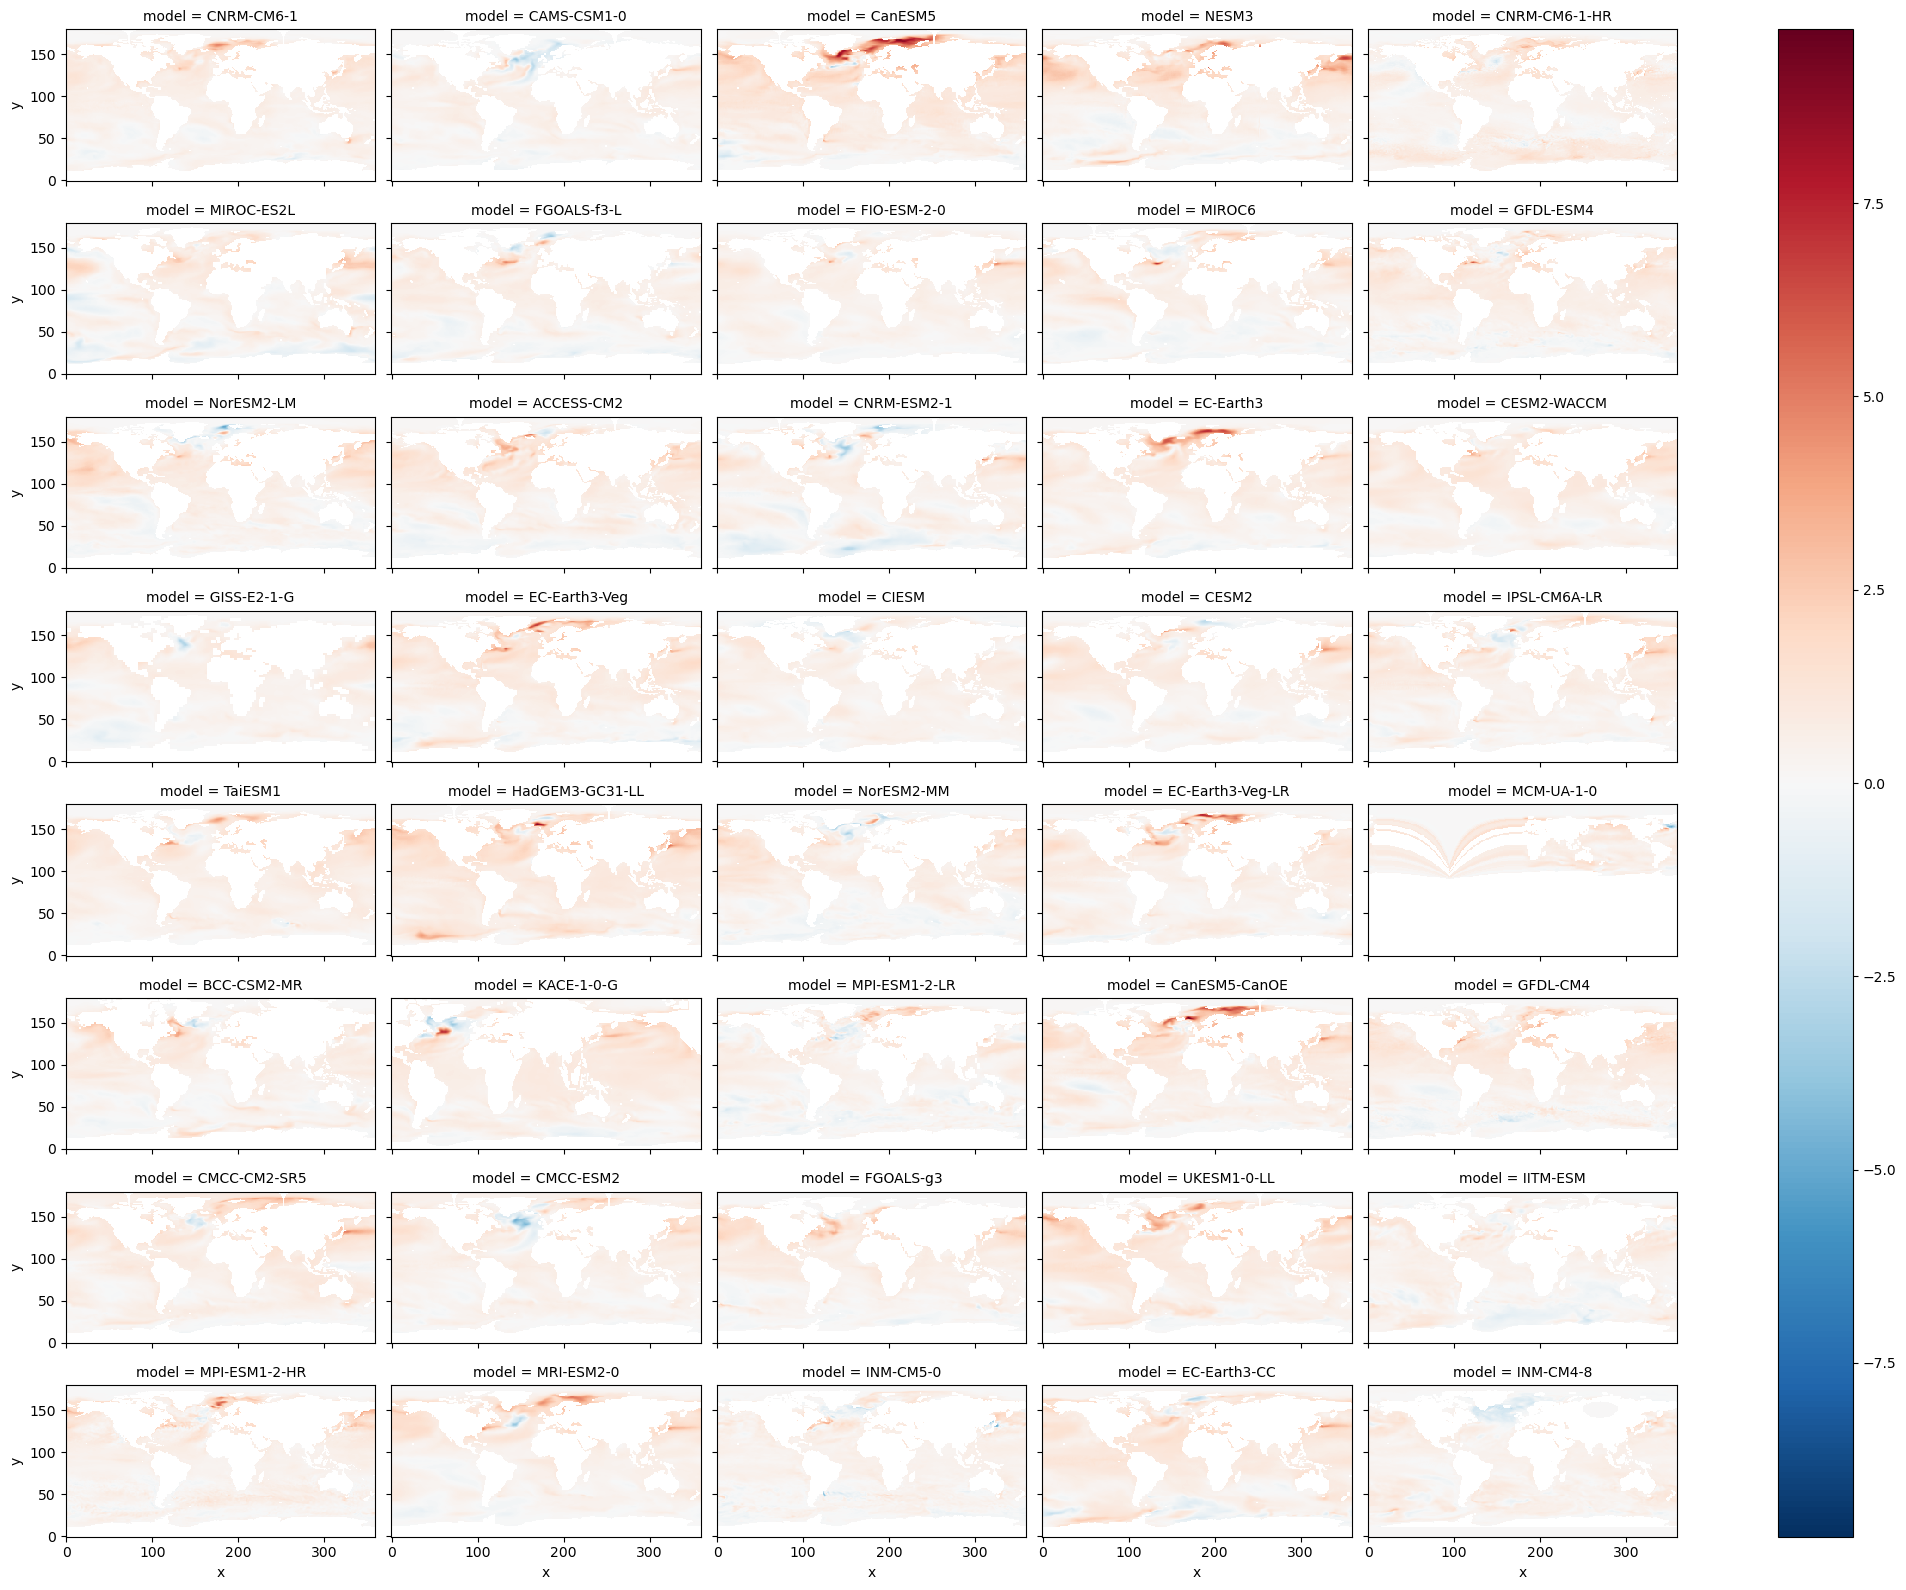

In [75]:
ds_merged.plot(col='model', col_wrap=5, aspect=2, size=2)

# Investigation of failed regridding cases:
- `MCM-UA-1-0` has faulty lat values (range[0-90] only)
- `KACE-1-0-G` has shifted lon values:
<div>
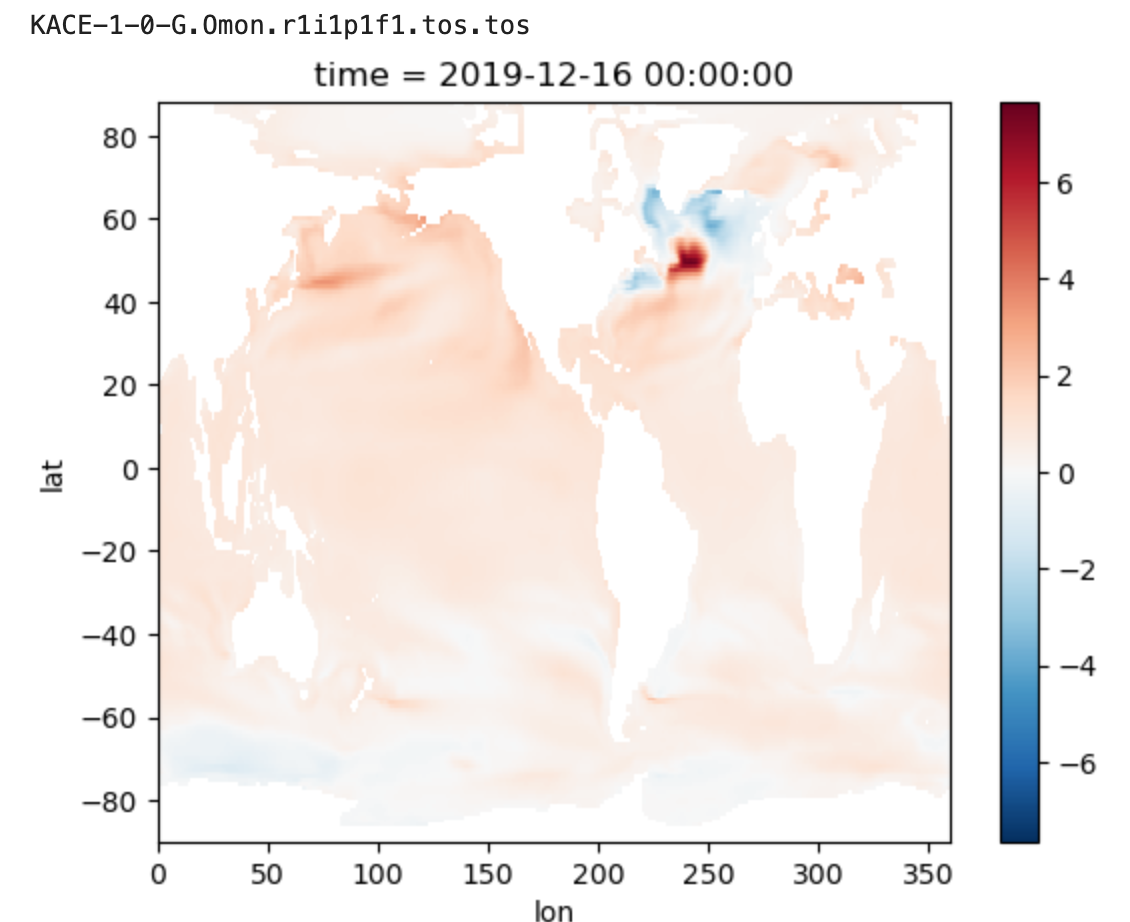
</div>

> This was the same for all members of `KACE-1-0-G`

These might be fixable, but for now Ill just exclude them from the final product.

In [69]:
ds_merged_clean = ds_merged.sel(model = [m for m in ds_merged.model.data if m not in ['MCM-UA-1-0', 'KACE-1-0-G']])
ds_merged_clean

<xarray.DataArray (model: 38, y: 180, x: 360)>
array([[[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [ 0.04703704,  0.0478031 ,  0.04856817, ...,  0.04473475,
          0.04550268,  0.04627018],
        [ 0.05422035,  0.05456155,  0.05490516, ...,  0.05320706,
          0.05354528,  0.05388159],
        [ 0.05521084,  0.05533525,  0.05549275, ...,  0.05484549,
          0.05496597,  0.05508775]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
...
        [ 0.11895178,  0.12013679,  0.12131377, ...,  0.11535187,
          0.11655898,  0.11775906],
        [ 0.11102945,  0.11164502,  0.11225489, ...,  0.1091509 ,
          0.10978238,  0.11040846],
        [ 0.1064755 ,  0.10663917,  0.1068061 , ...,  0.10597655,
          0.10614407,  0.10631043]],

       [[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [ 0.0284978 ,  0.02855328,  0.02858936, ...,  0.01896197,
          0.02836029,  0.02845366],
        [ 0.02288301,  0.02280595,  0.02273462, ...,  0.0281294 ,
          0.02852246,  0.02306735],
        [ 0.00475961,  0.00478949,  0.00479079, ...,  0.02321736,
          0.02305057,  0.00798327]]])
Coordinates:
    lat      (y, x) float64 -89.5 -89.5 -89.5 -89.5 ... 89.5 89.5 89.5 89.5
    lon      (y, x) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * model    (model) <U16 'CNRM-CM6-1' 'CAMS-CSM1-0' ... 'INM-CM4-8'
Dimensions without coordinates: y, x
Attributes:
    regrid_method:  bilinear

In [70]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

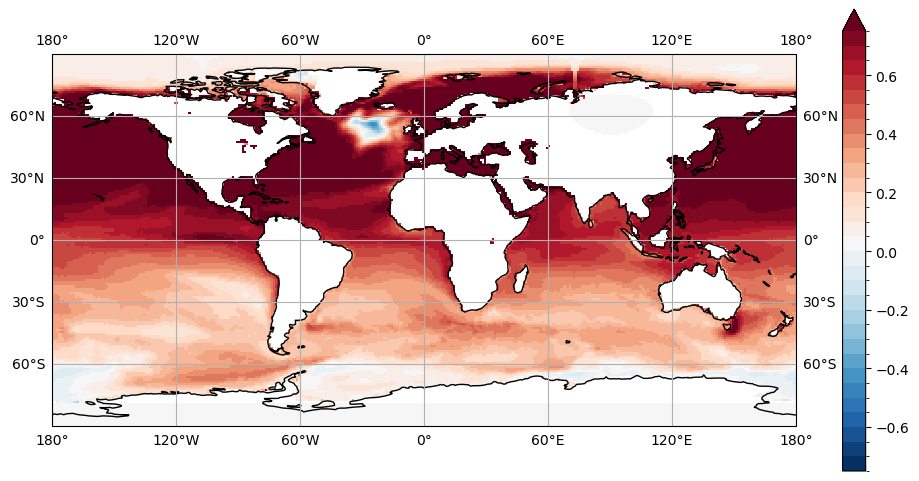

In [71]:
fig, ax = plt.subplots(subplot_kw=dict(projection=ccrs.PlateCarree()), figsize=[12,6])
ds_merged_clean.mean('model').plot(vmax=0.75, x='lon', y='lat', transform=ccrs.PlateCarree(), levels=31)
ax.gridlines(draw_labels=True)
ax.coastlines()

In [ ]:
a = ds_merged_clean.plot(
    col='model',
    col_wrap=6,
    vmax=6,
    subplot_kws=dict(projection=ccrs.PlateCarree()),
    x='lon',
    y='lat',
    transform=ccrs.PlateCarree(),
    size = 2, 
    aspect = 2,
)
for ax in a.axs.flat:
    ax.gridlines(draw_labels=False)
    ax.coastlines()

## Save out final data to nc file

In [ ]:
ds_merged_clean.to_netcdf('CMIP6_tos_trend.nc')